In [6]:
from preprocessor import text_preprocessing
from gspan_mining import gSpan
from gspan_mining.graph import Graph
from database import Database
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from nltk.tokenize import word_tokenize
from dotenv import load_dotenv
import nltk
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import os
from classification_vector import k_nearest_neighbour, vectorize_text


nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/himangsu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/himangsu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/himangsu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [20]:
def split_train_test_data(documents, train_ratio=0.8):
    """
    Split the dataset into training and testing sets.

    Args:
        documents (list): List of documents.
        train_ratio (float): Ratio of training data to total data.

    Returns:
        tuple: Train and test data sets.
    """
    test_ratio = 1 - train_ratio
    category_data = defaultdict(list)
    for document in documents:
        category_data[document['category']].append(document)
    train_data = []
    test_data = []
    for category, category_items in category_data.items():
        texts = [item['preprocessed-text'] for item in category_items]
        labels = [item['category'] for item in category_items]
        X_train, X_test, y_train, y_test = train_test_split(
            texts, labels, test_size=test_ratio)
        train_data.extend([{'preprocessed-text': text, 'category': label}
                          for text, label in zip(X_train, y_train)])
        test_data.extend([{'preprocessed-text': text, 'category': label}
                         for text, label in zip(X_test, y_test)])
    return train_data, test_data


In [21]:
def create_graph(text):
    G=nx.DiGraph()
    previous_word=None
    for word in word_tokenize(text):
        if word not in G:
            G.add_node(word)
        if previous_word:
            if G.has_edge(previous_word,word):
                G[previous_word][word]['weight']+=1
            else:
                G.add_edge(previous_word,word,weight=1)
            
        previous_word=word
    return G


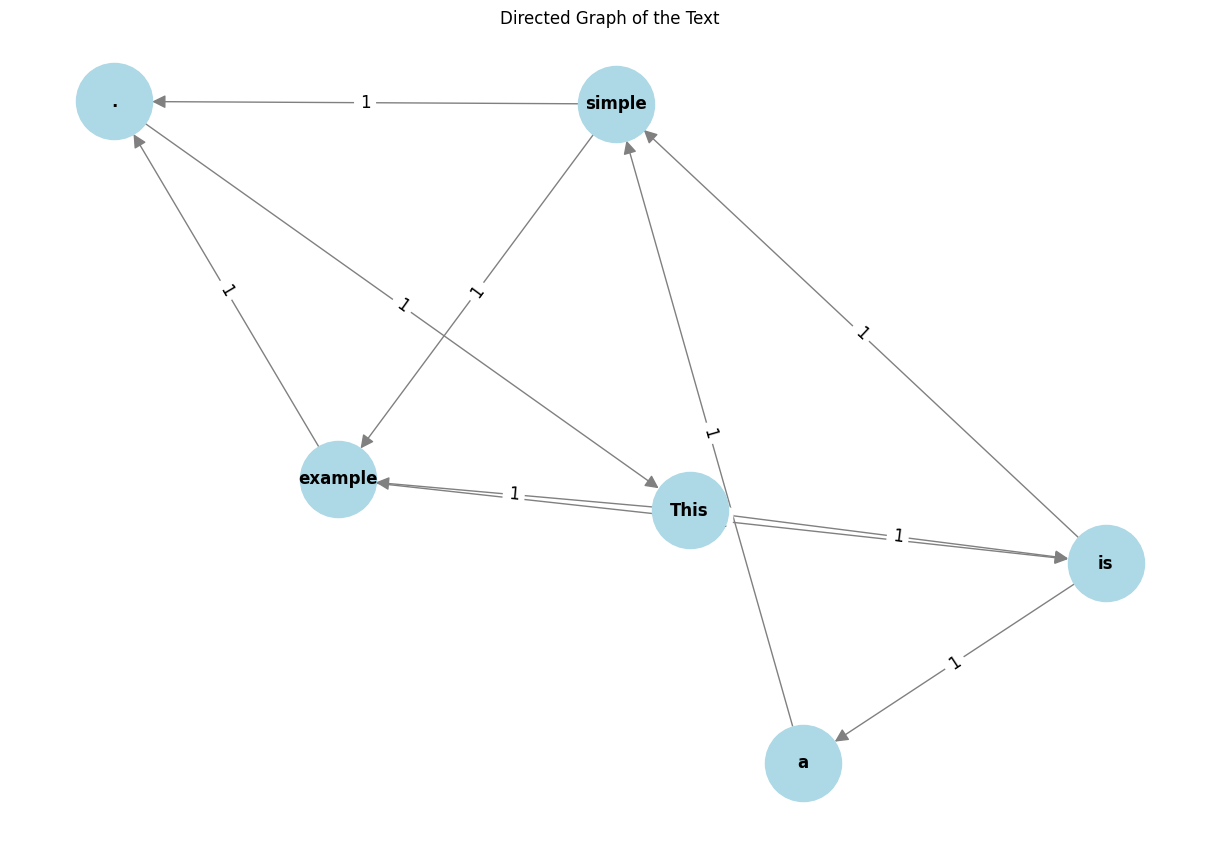

In [22]:
text = "This is a simple example. This example is simple."
graph = create_graph(text)

# Drawing the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=12, font_weight='bold', arrowsize=20)
edge_labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=12)
plt.title("Directed Graph of the Text")
plt.show()

In [23]:
def knn(train_data, test_instance, k):
    """
    Perform k-nearest neighbors classification.

    Args:
        train_data (list): List of training instances.
        test_instance (nx.DiGraph): Test instance.
        k (int): Number of nearest neighbors to consider.

    Returns:
        str: Predicted class label.
    """
    distances = []
    for train_instance, category in train_data:
        distance = mcs_distance(test_instance, train_instance)
        distances.append((category, distance))
    distances.sort(key=lambda x: x[1])
    neighbors = distances[:k]
    class_counts = defaultdict(int)
    for neighbor in neighbors:
        class_counts[neighbor[0]] += 1
    predicted_class = max(class_counts, key=class_counts.get)
    return predicted_class


def find_mcs(graph_list):
    """
    Finds the Maximum Common Subgraph (MCS) for a list of graphs.

    Args:
        graph_list (list): List of NetworkX graphs.

    Returns:
        nx.Graph: Graph representing the MCS.
    """
    mcs_graph = nx.Graph()
    common_nodes = set.intersection(*[set(g.nodes) for g in graph_list])
    mcs_graph.add_nodes_from(common_nodes)
    for node1 in common_nodes:
        for node2 in common_nodes:
            if all(g.has_edge(node1, node2) for g in graph_list):
                mcs_graph.add_edge(node1, node2)
    return mcs_graph


def mcs_distance(graph1, graph2):
    """
    Calculates the graph distance between two graphs based on the MCS size.

    Args:
        graph1 (nx.DiGraph): First graph.
        graph2 (nx.DiGraph): Second graph.

    Returns:
        float: Graph distance.
    """
    mcs = find_mcs([graph1, graph2])
    return 1 - len(mcs.nodes) / max(len(graph1.edges), len(graph2.edges))


def random_article(graphs, text, k=3):
    """
    Classify a random article based on its text.

    Args:
        graphs (list): List of training graphs.
        text (str): Text of the article.
        k (int): Number of nearest neighbors to consider.

    Returns:
        str: Predicted class label.
    """
    preprocessed_text = text_preprocessing(text)

    test_instance = create_graph(preprocessed_text)

    predicted_class = knn(graphs, test_instance, k)

    print(f'Predicted class: {predicted_class}')

    return predicted_class


In [30]:
load_dotenv()
uri = os.getenv('MONGO_URL')
db = Database('Document-Classification-DB', 'Articles', uri)
documents = db.get_all_data()



train_data, test_data = split_train_test_data(documents, 0.8)

train_graphs = [(create_graph(doc['preprocessed-text']),
                     doc['category']) for doc in train_data]
test_graphs = [(create_graph(doc['preprocessed-text']),
                    doc['category']) for doc in test_data]

# k = 3
# predictions = []
# true_labels = []
# for test_instance, category in test_graphs:
#         predicted_class = knn(train_graphs, test_instance, k)
#         predictions.append(predicted_class)
#         true_labels.append(category)
#         print(f'Predicted class: {predicted_class}, Actual Class: {category}')

# print("Classification Report:")
# print(classification_report(true_labels, predictions))
# print(confusion_matrix(true_labels, predictions))

# X_train = [entry['preprocessed-text'] for entry in train_data]
# y_train = [entry['category'] for entry in train_data]
# X_test = [entry['preprocessed-text'] for entry in test_data]
# y_test = [entry['category'] for entry in test_data]

#     # Vectorize text data
# X_train_vec, X_test_vec = vectorize_text(X_train, X_test)

# y_pred = k_nearest_neighbour(X_train_vec, y_train, X_test_vec, k)
# print(classification_report(y_test, y_pred))
# print(confusion_matrix(y_test, y_pred))

KeyError: 'preprocessed-text'

In [29]:
k = 3
predictions = []
true_labels = []
for test_instance, category in test_graphs:
        predicted_class = knn(train_graphs, test_instance, k)
        predictions.append(predicted_class)
        true_labels.append(category)
        print(f'Predicted class: {predicted_class}, Actual Class: {category}')

print("Classification Report:")
print(classification_report(true_labels, predictions))
print(confusion_matrix(true_labels, predictions))

X_train = [entry['preprocessed-text'] for entry in train_data]
y_train = [entry['category'] for entry in train_data]
X_test = [entry['preprocessed-text'] for entry in test_data]
y_test = [entry['category'] for entry in test_data]

    # Vectorize text data
X_train_vec, X_test_vec = vectorize_text(X_train, X_test)

y_pred = k_nearest_neighbour(X_train_vec, y_train, X_test_vec, k)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Predicted class: Food, Actual Class: Food
Predicted class: Food, Actual Class: Food
Predicted class: Food, Actual Class: Food
Predicted class: Food, Actual Class: Food
Predicted class: Food, Actual Class: Food
Predicted class: Food, Actual Class: Food
Classification Report:
              precision    recall  f1-score   support

        Food       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

[[6]]


/home/himangsu/Code/python_projects/Document_Classification-using-KNN/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


TypeError: 'KNeighborsClassifier' object is not callable

In [33]:
load_dotenv()
uri = os.getenv('MONGO_URL')
db = Database('Document-Classification-DB', 'Articles', uri)
documents = db.get_all_data()
category_data = defaultdict(list)
for document in documents:
        category_data[document['category']].append(document)

In [34]:
category_data

defaultdict(list,
            {'Business & Finance': [{'_id': ObjectId('669e669b90a28c851b9dcf55'),
               'url': '',
               'category': 'Business & Finance',
               'title': '',
               'text': 'Tips Every Freelance Content Writer Should Know \n  Content creation rarely happens quickly. Even experienced writers rarely produce their best work on the first draft. They revise their work several times before getting their articles out the door. In fact, the best articles you read in prestigious magazines always get some help. Just like a diva looking ravishing on the red carpet after fashion stylists, make-up artists, and hair and nail experts have done their best to prep her, so does an excellent piece of writing benefit from different inputs before being published. The truth is that many famous bloggers and authors research and then write their drafts, but a skilled editor and proofreader always comes behind to wrap up their work and finish the process. Un

In [35]:
category_data.items()

dict_items([('Business & Finance', [{'_id': ObjectId('669e669b90a28c851b9dcf55'), 'url': '', 'category': 'Business & Finance', 'title': '', 'text': 'Tips Every Freelance Content Writer Should Know \n  Content creation rarely happens quickly. Even experienced writers rarely produce their best work on the first draft. They revise their work several times before getting their articles out the door. In fact, the best articles you read in prestigious magazines always get some help. Just like a diva looking ravishing on the red carpet after fashion stylists, make-up artists, and hair and nail experts have done their best to prep her, so does an excellent piece of writing benefit from different inputs before being published. The truth is that many famous bloggers and authors research and then write their drafts, but a skilled editor and proofreader always comes behind to wrap up their work and finish the process. Unfortunately, up to recently, most freelance writers couldn’t afford this luxur

In [45]:
for category, category_items in category_data.items():
        print(category_items)

TypeError: list indices must be integers or slices, not str